In [1]:
'''Example of VAE on MNIST dataset using CNN
The VAE has a modular design. The encoder, decoder and VAE
are 3 models that share weights. After training the VAE model,
the encoder can be used to  generate latent vectors.
The decoder can be used to generate MNIST digits by sampling the
latent vector from a Gaussian distribution with mean=0 and std=1.
# Reference
[1] Kingma, Diederik P., and Max Welling.
"Auto-encoding variational bayes."~
https://arxiv.org/abs/1312.6114
'''

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.layers import Conv2D, Flatten, Lambda
from tensorflow.keras.layers import Reshape, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.losses import mse, binary_crossentropy
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
import argparse
import os


# reparameterization trick
# instead of sampling from Q(z|X), sample eps = N(0,I)
# then z = z_mean + sqrt(var)*eps
def sampling(args):
    """Reparameterization trick by sampling
        fr an isotropic unit Gaussian.
    # Arguments:
        args (tensor): mean and log of variance of Q(z|X)
    # Returns:
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon


import pandas as pd
import numpy as np
import seaborn as sns
from keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector
from keras.models import Model
import numpy as np

from tensorflow.keras.layers import Conv1D
import matplotlib.pyplot as plt
import keras
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector, Dropout
from tensorflow.keras.layers import Flatten, Dense, Dropout, Lambda
from tensorflow.keras.optimizers import SGD, RMSprop, Adam
import tensorflow as tf

from keras.regularizers import l1,l2
import warnings
warnings.filterwarnings('ignore')

def load_dataset (path):

    df = pd.read_csv(path)
    pd.set_option('display.max_columns', None)
    time = df['(PDH-CSV 4.0) (Coordinated Universal Time)(0)']
    cpu = df['\\\\zneudl1p52itb8\\processor(_total)\\% processor time']
    ram = df['\\\\zneudl1p52itb8\\memory\\% committed bytes in use']
    disk_bytes = df['\\\\zneudl1p52itb8\\logicaldisk(c:)\\disk write bytes/sec']
    disk_sec = df['\\\\zneudl1p52itb8\\logicaldisk(c:)\\avg. disk sec/write']
    df = df.replace(r'^\s*$', np.nan, regex=True)
    d0 = {'cpu':cpu}
    CPU=pd.DataFrame(data=d0)
    d1 = {'disk_sec':disk_sec}
    DISK_SEC=pd.DataFrame(data=d1)
    d2 = {'disk_bytes':disk_bytes}
    DISK_BYTES=pd.DataFrame(data=d2)
    d3 = {'ram':ram}
    RAM=pd.DataFrame(data=d3)
    df=pd.concat([CPU,DISK_SEC,DISK_BYTES,RAM],axis=1)

    data= np.concatenate([CPU,DISK_SEC,DISK_BYTES,RAM],axis=1)
    return  data

In [5]:
def windowing(data, window_size):
    #window_size = 50
    windowed_data_size = round(data.shape[0]/window_size) -1 #gets size of data and divides by 50 (window size)
    variable_size = data.shape[1]
    windowed_data = np.zeros((windowed_data_size,window_size,variable_size)) #3D array dims see vars in func
    for i in range(windowed_data_size):

        sample = data[i*window_size:(i*window_size)+window_size,:]
        windowed_data[i,:,:] = sample
    return  windowed_data, windowed_data_size,variable_size

In [6]:
from sklearn.preprocessing import MinMaxScaler

def scaling(windowed_data, scalling_type,windowed_data_size,window_size):

    if scalling_type =="minmax":
        scaler = MinMaxScaler()

    scaled_data = np.zeros((windowed_data_size,window_size,4))
    for i in range(windowed_data_size):
        sample = windowed_data[i,:,:]
        scaled_data_sample = scaler.fit_transform(sample)
        scaled_data[i,:,:] = scaled_data_sample
    return scaled_data

In [7]:
def custom_loss(y_true, y_pred):
    kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5

    reconstruction_loss = binary_crossentropy(y_true[0], y_pred[0])
    reconstruction_loss *= window_size * 4 * 1

    # y_pred = predOutputs

    prediction_loss = K.square(y_pred[1] - y_true[1])

    total_loss = K.mean(prediction_loss, axis=-1) + K.mean(reconstruction_loss) + K.mean(kl_loss)
    return total_loss

In [13]:
# VAE model = encoder + decoder
# build encoder model
def buildencoder(input_shape, filters, kernel_size, latent_dim, drop_out, regularisation_used):
    
    inputs = Input(shape=input_shape, name='encoder_input')
    x = inputs
    for i in range(2):
        filters *= 2
        x = Conv2D(filters=filters,
                   kernel_size=kernel_size,
                   activation='relu',
                   strides=2,
                   padding='same')(x)

    # shape info needed to build decoder model
    shape = K.int_shape(x)

    # generate latent vector Q(z|X)
    x = Flatten()(x)
    
    if drop_out > 0:
        x = Dropout(drop_out)(x)
    
    x = Dense(128, activation='relu')(x)
    
    if regularisation_used == 1:
        z_mean = Dense(latent_dim,activity_regularizer=l2(0.01), name='z_mean')(x)
        z_log_var = Dense(latent_dim, activity_regularizer=l2(0.01), name='z_log_var')(x)   
    else:  
        z_mean = Dense(latent_dim, name='z_mean')(x)
        z_log_var = Dense(latent_dim, name='z_log_var')(x)
        
        
    if drop_out > 0:
        z_mean = Dropout(drop_out)(z_mean)
        z_log_var = Dropout(drop_out)(z_log_var)
        
    # use reparameterization trick to push the sampling out as input
    # note that "output_shape" isn't necessary
    # with the TensorFlow backend
    z = Lambda(sampling,
               output_shape=(latent_dim,),
               name='z')([z_mean, z_log_var])

    # instantiate encoder model
    encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
    encoder.summary()
    
    return [inputs, shape, encoder]


In [10]:
# build decoder model

def builddecoder(latent_dim, shape, filters, kernel_size, window_size, encoder, inputs, drop_out):
    
    latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
    x = Dense(shape[1] * shape[2] * shape[3],
              activation='relu')(latent_inputs)

    if drop_out > 0:
        x = Dropout(drop_out)(x)

    x = Reshape((shape[1], shape[2], shape[3]))(x)

    for i in range(2):
        x = Conv2DTranspose(filters=filters,
                            kernel_size=kernel_size,
                            activation='relu',
                            strides=2,
                            padding='same')(x)
        filters //= 2

    outputs = Conv2DTranspose(filters=1,
                              kernel_size=kernel_size,
                              activation='sigmoid',
                              padding='same',
                              name='decoder_output')(x)

    outputs = Dense(1, name='outputs')(outputs)
    outputs = tf.image.resize(outputs, [window_size, 4])


    # instantiate decoder model
    decoder = Model(latent_inputs, outputs, name='decoder')
    decoder.summary()

    # instantiate VAE model
    outputs = decoder(encoder(inputs)[2])
    vae = Model(inputs, outputs, name='vae')
    vae.summary()
    
    return vae

In [11]:
from sklearn.model_selection import KFold

def Training_run (vae, Xx_train, Xx_test, training_type, num_folds):

    print('-------------------------------------------------------------------')
    print('-------------------------------------------------------------------')
    print('Starting training run...')
    print('-------------------------------------------------------------------')
    print('-------------------------------------------------------------------')
    
    if training_type == 0:
        history = vae.fit(Xx_train, Xx_train, validation_data=(Xx_test, Xx_test), epochs=epochs)
    else:

        # Define the K-fold Cross Validator
        kfold = KFold(n_splits=num_folds, shuffle=True)

        # K-fold Cross Validation model evaluation
        #fold_no = 0
        inputs = np.concatenate((Xx_train, Xx_test), axis=0)
        targets = np.concatenate((Xx_train, Xx_test), axis=0)
        # Define per-fold score containers
        acc_per_fold = []
        loss_per_fold = []
        
        # One training round!!!!
        trainig_round = 3
        

        for trainig_round_session in range(trainig_round):
            fold_no = 0
            for train, test in kfold.split(inputs, targets):
                # Generate a print
                print('------------------------------------------------------------------------')
                print(f'Training for fold {fold_no} ...')

                # Fit data to model
                history = vae.fit(inputs[train], targets[train],
                                  validation_data=(inputs[test], targets[test]), epochs=epochs)

                # Generate generalization metrics
                scores = vae.evaluate(inputs[test], targets[test], verbose=0)
                print('Score for fold', fold_no, scores)
                # acc_per_fold.append(scores)
                loss_per_fold.append(scores)

                # Increase fold number
                fold_no = fold_no + 1

    return history

In [2]:
# Set path and retrieve raw data
path = 'C:/Users/rsers/Documents/Python Environments/Data Reformatter/project/logs.csv'
data = load_dataset(path)

In [4]:
data

array([[1.87489900e+01, 1.87025313e-03, 2.49681574e+05, 5.31539147e+01],
       [2.10808103e+00, 3.65442857e-04, 1.05896688e+05, 5.31551355e+01],
       [5.57183765e+00, 1.94333333e-04, 1.11255411e+06, 5.31319412e+01],
       ...,
       [4.69146164e-01, 1.59460000e-04, 3.23600210e+04, 5.29768677e+01],
       [3.51878051e-01, 3.36750000e-04, 2.03303201e+04, 5.29716795e+01],
       [2.86071935e+00, 8.56033333e-04, 1.22720439e+05, 5.29714697e+01]])

In [ ]:
from sklearn.model_selection import train_test_split
import json
    
# Set path and retrieve raw data
path = 'C:/Users/rsers/Documents/Python Environments/Data Reformatter/project/logs.csv'
data = load_dataset(path)

# Set path and retrieve hyperparam data
file_path = 'C:/Users/rsers/Documents/Python Environments/CNN-Anom/data.json'

with open(file_path, 'r') as j:
        space = json.loads(j.read())
        print(space)

# Try 10 combinations of hyperparams - Initially no cross validation
for model in range(1):
    
    window_size = 20
    batch_size = 128
    kernel_size = 3
    filters = 128

        #intermediate_dim = int(random.choice(list(space['intermediate_dim'][0].values())))
    latent_dim = 200
    regularisation_used = 2
    drop_out = 0.1
    training_type = 1
    epochs = 100
    num_folds = 10
    ## choose random hyperspace parameters
#     import random
#     window_size = int(random.choice(list(space['window_size'][0].values())))
#     batch_size = int(random.choice(list(space['batch_size'][0].values())))
#     kernel_size = int(random.choice(list(space['kernel_size'][0].values())))
#     filters = int(random.choice(list(space['filters'][0].values())))
    
#     #intermediate_dim = int(random.choice(list(space['intermediate_dim'][0].values())))
#     latent_dim = int(random.choice(list(space['latent_dim'][0].values())))
#     regularisation_used = int(random.choice(list(space['regularisation_used'][0].values())))
#     drop_out = float(random.choice(list(space['drop_out'][0].values())))
#     training_type = int(random.choice(list(space['training_type'][0].values())))
#     epochs = int(random.choice(list(space['epochs'][0].values())))
#     num_folds = int(random.choice(list(space['num_folds'][0].values())))



#     # Set Hyper parameters
#     window_size = 30
#     input_shape = (window_size, 4, 1)
#     batch_size = 128
#     kernel_size = 3
#     filters = 64
#     latent_dim = 100
#     epochs = 200

    # Display selected params
    print('=====================================================================================')
    print('Selected Hyperparameters: ',
              f"window_size {window_size}, batch_size {batch_size}, kernel_size {kernel_size},",
              f"filters {filters}, latent_dim {latent_dim},",
              f"regularisation_used {regularisation_used}, drop_out {drop_out}, training_type {training_type},",
              f"epochs {epochs}, num_folds {num_folds}")
    print('=====================================================================================')
    

    # Segment data into chunks defined by window size H * W => window_size * 4 features
    [windowed_data,windowed_data_size,variable_size] = windowing(data, window_size)

    # Scale data to reduce potential negative bias by large variations in data
    scalling_type = "minmax"
    scaled_data = scaling(windowed_data, scalling_type,windowed_data_size,window_size )

    # Reshape data and format for 2D CNN
    Xx_train = scaled_data.reshape(scaled_data.shape[0], scaled_data.shape[1],scaled_data.shape[2],1)
    #Xx_train, Xx_test = train_test_split(Xx_train, test_size=20)
    Xx_trainn = scaled_data

    # Build encoder
    input_shape = (window_size, 4, 1)
    [inputs, shape, encoder] = buildencoder(input_shape, filters, kernel_size, latent_dim, 
                                            drop_out, regularisation_used)

    # Build decoder and combine to create full autoencoder
    vae = builddecoder(latent_dim, shape, filters, kernel_size, window_size, encoder, inputs, drop_out)

    # Compile Autoencoder
    vae.compile(optimizer='rmsprop',loss=mse)

    scaled_data = scaled_data.reshape(scaled_data.shape[0], scaled_data.shape[1],scaled_data.shape[2],1)
    Xx_train, Xx_test = train_test_split(scaled_data, test_size=0.33)

    # Train Model
    model_outcome = Training_run(vae, Xx_train, Xx_test, training_type, num_folds)
    
    
    #history = vae.fit(Xx_train, Xx_train, validation_data=(Xx_test, Xx_test), epochs=epochs)
    
    df_columns = ['loss', 'val_loss',
                    'window_size', 'batch_size', 'kernel_size',
                    'filters', 'latent_dim', 'regularisation_used',
                    'drop_out', 'training_type',
                    'epochs', 'num_folds'];
        
#     #Name the model set
#     name = "CNN_CNN_1"
#     Save the model and its weights
#     vae.save_weights(f"{name}_weights.h5")
#     vae.save(f"{name}_model.h5")
#     name = "model"
#     #Save the model and its weights
#     vae.save_weights("model_weights.h5")
#     vae.save(f"{name}")

    #del vae
    
    csv_str = 'hypertest.csv';
    # df.to_csv(csv_str, sep=',', index  = False)
    df_new = pd.DataFrame([[str(model_outcome.history['loss'][-1]), str(model_outcome.history['val_loss'][-1]),
                            str(window_size), str(batch_size),str(kernel_size),
                            str(filters), str(latent_dim),
                            str(regularisation_used),
                            str(drop_out), str(training_type),str(epochs), str(num_folds),
                            ]],
                              columns=df_columns)
    with open(csv_str, 'a') as f:
        #df_new.to_csv(f, header=False, index=False)
        df_new.to_csv(f, header=False, encoding='utf8', line_terminator='\n', index=False)


In [14]:
# Recreate model
window_size = 20
batch_size = 128
kernel_size = 3
filters = 128
latent_dim = 200
regularisation_used = 2
drop_out = 0.1
training_type = 1
epochs = 100
num_folds = 10

# Build encoder
input_shape = (window_size, 4, 1)
[inputs, shape, encoder] = buildencoder(input_shape, filters, kernel_size, latent_dim, 
                                        drop_out, regularisation_used)

# Build decoder and combine to create full autoencoder
vae = builddecoder(latent_dim, shape, filters, kernel_size, window_size, encoder, inputs, drop_out)

# Compile Autoencoder
vae.compile(optimizer='rmsprop',loss=mse)

vae.load_weights('CNN_CNN_1_weights.h5')

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 20, 4, 1)]   0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 10, 2, 256)   2560        ['encoder_input[0][0]']          
                                                                                                  
 conv2d_1 (Conv2D)              (None, 5, 1, 512)    1180160     ['conv2d[0][0]']                 
                                                                                                  
 flatten (Flatten)              (None, 2560)         0           ['conv2d_1[0][0]']               
                                                                                            

In [15]:
from sklearn.model_selection import train_test_split
# Set path and retrieve raw data
path = 'C:/Users/rsers/Documents/Python Environments/Data Reformatter/project/logs.csv'
data = load_dataset(path)

# Segment data into chunks defined by window size H * W => window_size * 4 features
[windowed_data,windowed_data_size,variable_size] = windowing(data, window_size)

# Scale data to reduce potential negative bias by large variations in data
scalling_type = "minmax"
scaled_data = scaling(windowed_data, scalling_type,windowed_data_size,window_size )

scaled_data = scaled_data.reshape(scaled_data.shape[0], scaled_data.shape[1],scaled_data.shape[2],1)
Xx_train, Xx_test = train_test_split(scaled_data, test_size=0.33)

In [16]:
## plotting outcome
X_pred_train = vae.predict(Xx_train[0:10,:,:])

X_pred_test = vae.predict(Xx_test[0:10,:,:])

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [60]:
print(X_pred_train[i,:,0,0])

[0.5912391  0.28169042 0.20891798 0.4433474  0.5235996  0.37149382
 0.97174126 0.00984311 0.8008682  0.29329658 0.31338042 0.12787521
 0.22931755 0.41016507 0.77454865 0.31104314 0.29680938 0.47391182
 0.20876431 0.7653471 ]


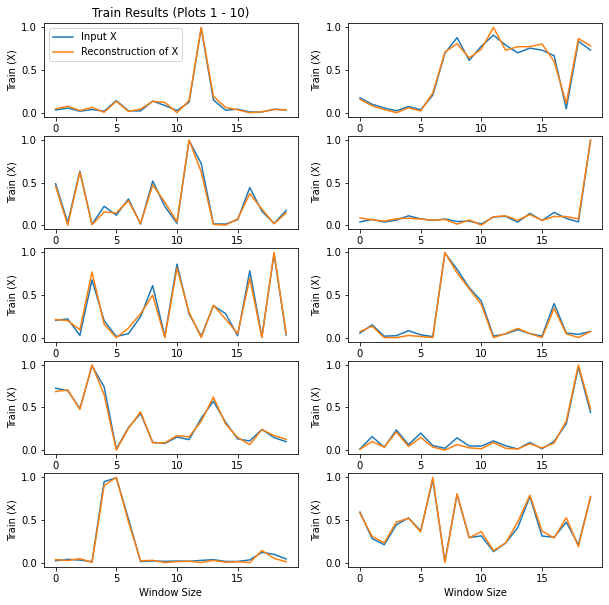

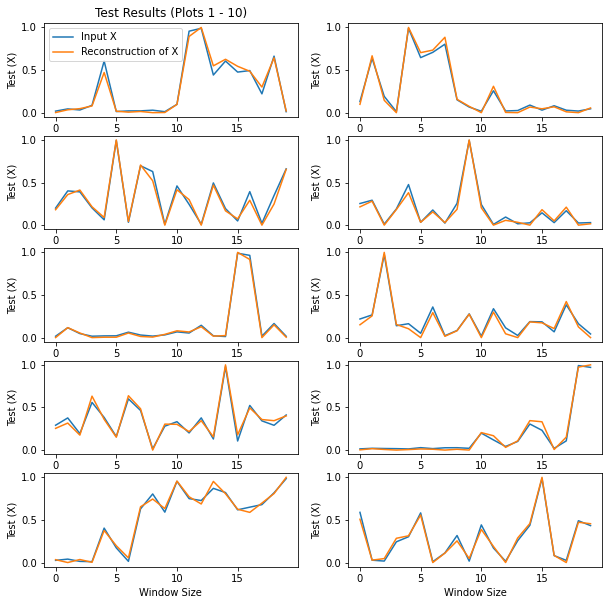

In [66]:
fig = plt.figure()

for i in range(10):
    plt.subplot(5, 2, (i+1))
    plt.plot(X_pred_train[i,:,0,0], label='Input X')
    plt.plot(Xx_train[i,:,0,0], label='Reconstruction of X')
#plt.legend('Raw Input','Reconstructed Input')
    plt.ylabel('Train (X)')
    if (i == 0):
        plt.title('Train Results (Plots 1 - 10)')
        plt.legend(loc="upper left")
    elif (i == 8 or i == 9 ):
        plt.xlabel('Window Size')
    
g = plt.figure()

for i in range(10):
    plt.subplot(5, 2, (i+1))
    plt.plot(X_pred_test[i,:,0,0], label='Input X')
    plt.plot(Xx_test[i,:,0,0], label='Reconstruction of X')

    plt.ylabel('Test (X)')
    if (i == 0):
        plt.title('Test Results (Plots 1 - 10)')
        plt.legend(loc="upper left")
    elif (i == 8 or i == 9 ):
        plt.xlabel('Window Size')
        
# Increase plot size
#plt.rcParams["figure.figsize"]=10,10

In [45]:
plt.plot(histroy_sample.history["loss"], label="Training Loss")
plt.plot(histroy_sample.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

NameError: name 'histroy_sample' is not defined

In [48]:
# Get train MAE loss.
train_mae_loss = np.mean(np.mean(np.abs(X_pred_train - Xx_train[0:10,:,:]), axis=1))
print('Train MAE loss: ', train_mae_loss)

test_mae_loss = np.mean(np.mean(np.mean(np.abs(X_pred_test - Xx_test[0,:,0,0]), axis=1)))
print('Test MAE loss: ', test_mae_loss)

Train MAE loss:  0.02563741339726456
Test MAE loss:  0.3340613718634566
